In [1]:
import datatable as dt
import numpy as np
import gc

assets_detail = dt.fread('./data/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
df_train = dt.fread('./data/cryptocurrency-extra-data-binance-coin/orig_train.jay').to_pandas()
def fill_target(x):
    return x.sort_values('timestamp').fillna(method='pad')
df_train = df_train.groupby('Asset_ID').apply(fill_target).reset_index(drop=True)
df_train.dropna(subset=['Target'], inplace= True)

#VWAP make finite
VWAP_max = np.max(df_train[np.isfinite(df_train.VWAP)].VWAP)
VWAP_min = np.min(df_train[np.isfinite(df_train.VWAP)].VWAP)
df_train['VWAP'] = np.nan_to_num(df_train.VWAP, posinf=VWAP_max, neginf=VWAP_min)
from script.memory_usage import reduce_mem_usage
df_train= reduce_mem_usage(df_train)
gc.collect()

Memory usage of dataframe is 2033.99 MB
int64->int32
int64->int8
float64->float32
float64->float32
float64->float32
float64->float32
float64->float32
float64->float32
float64->float32
float64->float32
Memory usage after optimization is: 1040.11 MB
Decreased by 48.9%


0

In [2]:
df_train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.379997,8.530000,-0.014399
1,1514764920,0,7.0,8.5300,8.5300,8.5145,8.5145,71.389999,8.520215,-0.015875
2,1514764980,0,45.0,8.5065,8.5299,8.4848,8.4848,1546.819946,8.501393,-0.015410
3,1514765040,0,14.0,8.5009,8.5066,8.4744,8.5009,125.800003,8.479810,-0.012524
4,1514765100,0,5.0,8.5007,8.5007,8.4560,8.4560,125.010002,8.458435,-0.005940


## Add log return

In [3]:
import pandas as pd
from math import sqrt, log

##add log_return
def log_return(df, periods=1):
    df['lrt_1'] = np.log(df['Close']).diff(periods=periods)
    return df

df_train = df_train.groupby('Asset_ID').apply(log_return)

In [4]:
df_train[df_train['Asset_ID']==2]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,lrt_1
3898901,1514764860,2,40.0,2376.580078,2399.500000,2357.139893,2374.590088,19.233006,2373.116455,-0.004218,NaN
3898902,1514764920,2,53.0,2374.553223,2400.899902,2354.199951,2372.286621,24.050259,2371.434570,-0.004079,-0.000970
3898903,1514764980,2,61.0,2371.633301,2401.899902,2353.699951,2372.063232,42.676437,2375.442871,-0.002892,-0.000094
3898904,1514765040,2,95.0,2376.060059,2406.399902,2344.000000,2370.566650,37.820919,2371.096191,-0.003718,-0.000631
3898905,1514765100,2,33.0,2372.656738,2404.600098,2343.399902,2370.173340,8.519679,2370.345703,-0.002171,-0.000166
...,...,...,...,...,...,...,...,...,...,...,...
5852433,1632182160,2,88.0,543.044006,543.190002,541.010010,541.901978,106.161072,542.316895,-0.000482,-0.002363
5852434,1632182220,2,178.0,540.526001,541.049988,538.090027,538.690002,124.443245,539.361206,-0.000482,-0.005945
5852435,1632182280,2,100.0,538.640015,539.239990,538.000000,538.775024,49.333530,538.611267,-0.000482,0.000158
5852436,1632182340,2,249.0,539.215027,542.700012,538.869995,542.512512,183.539307,541.018311,-0.000482,0.006913


In [5]:
df_lrt = df_train.pivot_table(index='timestamp',columns='Asset_ID', values='lrt_1')
df_lrt = df_lrt.fillna(method ='pad')
df_lrt.columns = [assets_detail[assets_detail['Asset_ID']==id]['Asset_Name'].item() for id in df_lrt.columns]

In [6]:
df_lrt.index = pd.to_datetime(df_lrt.index,unit='s')
df_lrt

,Binance Coin,Bitcoin,Bitcoin Cash,Cardano,Dogecoin,EOS.IO,Ethereum,Ethereum Classic,IOTA,Litecoin,Maker,Monero,Stellar,TRON
timestamp,,,,,,,,,,,,,,
2018-01-01 00:02:00,-0.001819,-0.001595,-0.000970,NaN,NaN,-0.000118,-0.000335,0.000772,NaN,-0.001555,NaN,NaN,NaN,NaN
2018-01-01 00:03:00,-0.003494,-0.001939,-0.000094,NaN,NaN,-0.000719,-0.001027,0.021866,NaN,0.005072,NaN,-0.000790,NaN,NaN
2018-01-01 00:04:00,0.001896,-0.002414,-0.000631,NaN,NaN,-0.002015,-0.000543,-0.000756,NaN,-0.007662,NaN,-0.003134,NaN,NaN
2018-01-01 00:05:00,-0.005296,-0.003138,-0.000166,NaN,NaN,-0.003384,-0.001898,-0.000473,NaN,-0.002030,NaN,-0.002227,NaN,NaN
2018-01-01 00:06:00,-0.006644,-0.000568,-0.001134,NaN,NaN,-0.005006,-0.000687,-0.001400,NaN,-0.003099,NaN,0.013680,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-20 23:56:00,-0.003282,-0.002007,-0.002363,-0.007796,-0.003144,-0.003516,-0.003137,-0.001912,-0.004869,-0.002359,-0.003641,-0.002766,-0.003261,-0.002754
2021-09-20 23:57:00,-0.001980,-0.000910,-0.005945,-0.000610,-0.002531,-0.002115,-0.001305,-0.004157,-0.002737,-0.003906,-0.002640,-0.003065,-0.002748,-0.003939
2021-09-20 23:58:00,-0.000945,-0.000770,0.000158,-0.000583,-0.000596,-0.000822,-0.001165,-0.001059,-0.001528,-0.001038,0.000692,-0.000552,-0.002100,-0.000041


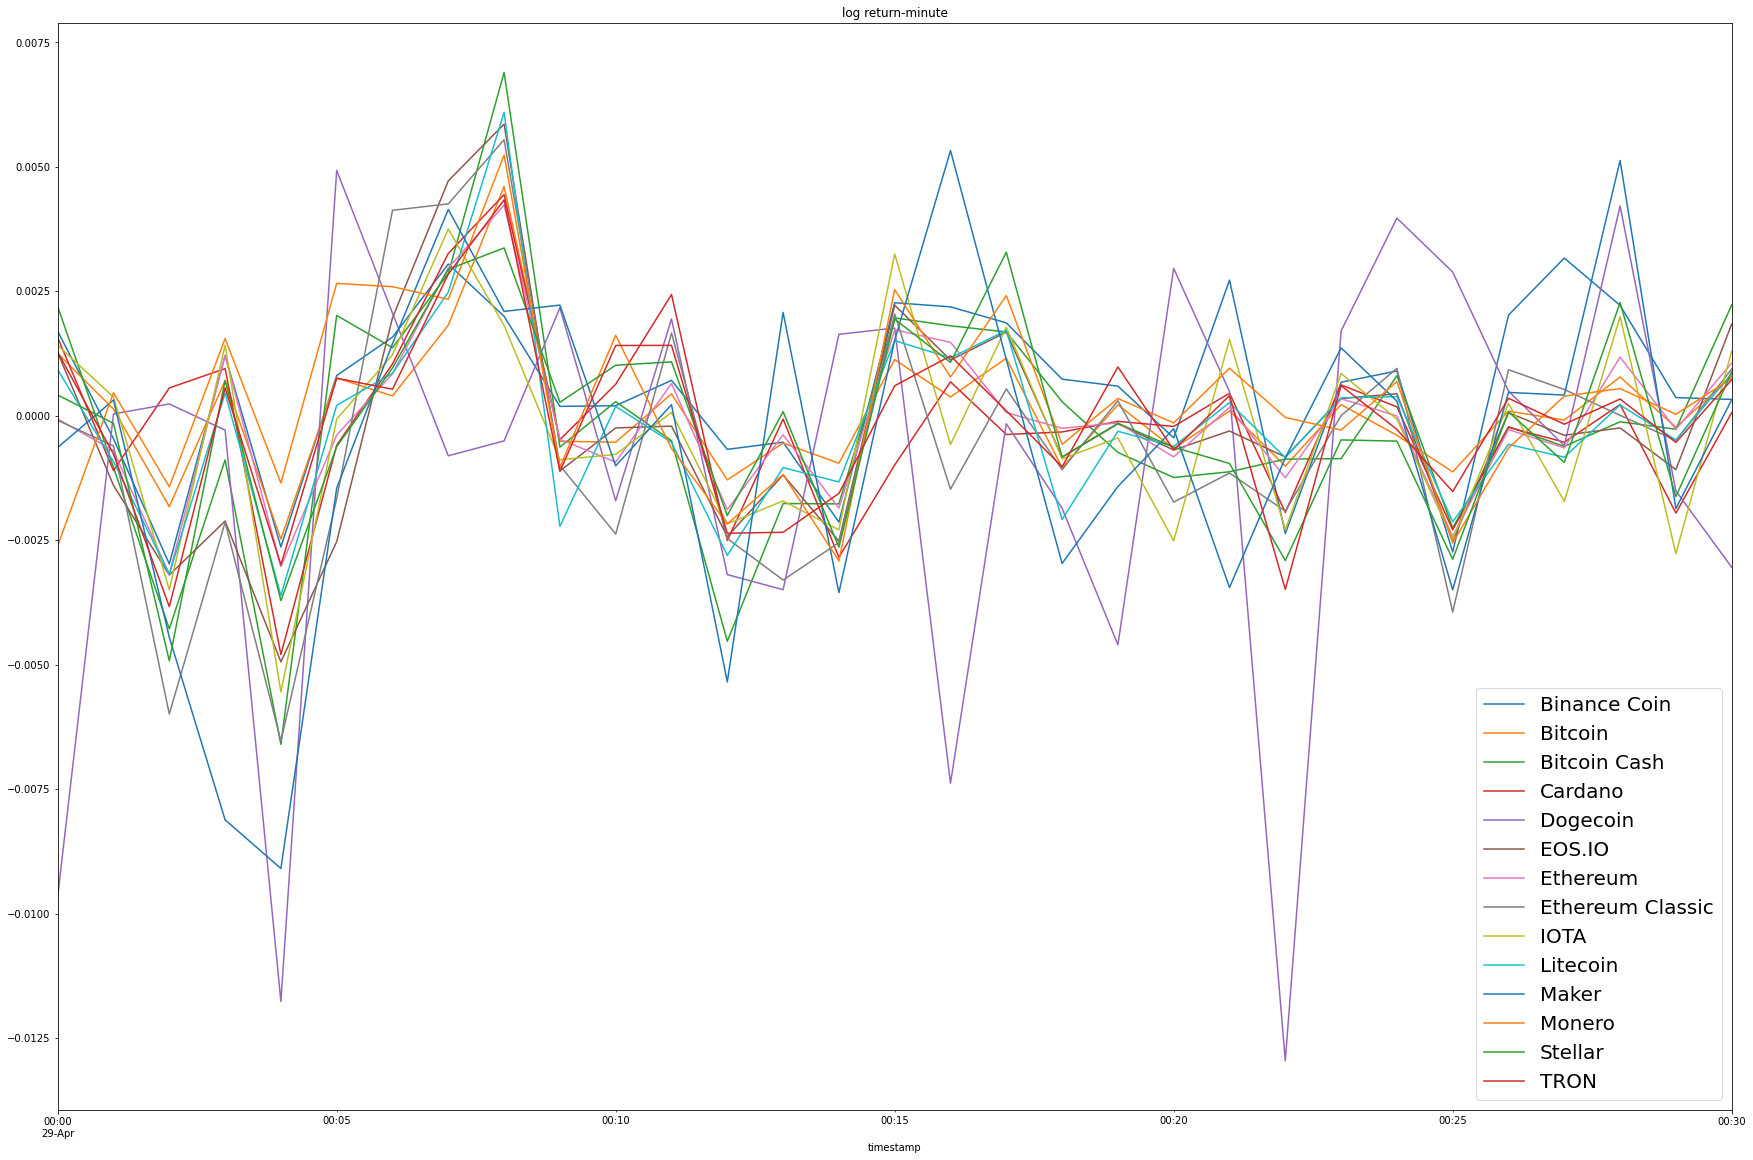

In [7]:
df_lrt['2021-04-29 00:00:00':'2021-04-29 00:30:00'].plot(figsize = (30,20),title = 'log return-minute').legend(loc='lower right',prop={'size': 20})

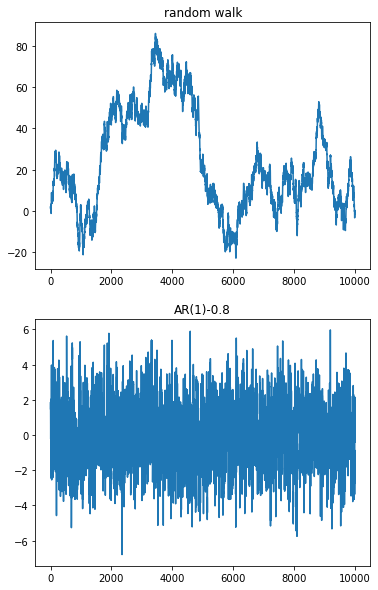

In [8]:
from matplotlib import pyplot as plt
np.random.seed(2021)
fig = plt.figure(figsize=(6,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

e = np.random.randn(10000)
example_non = e.cumsum()
ax1.plot(example_non)
ax1.title.set_text('random walk')

example_stat =[0]
for i in range(len(e)):
    example_stat.append(example_stat[-1]*0.8 + e[i])
ax2.plot(example_stat[1:])
ax2.title.set_text('AR(1)-0.8')

## run paper statistics

In [9]:
from script.paper.paperClass import paperCI
from scipy.stats import norm
start_dt = '2021-07-28 16:00:00'
start_dt = pd.to_datetime(start_dt)
end_dt = start_dt+pd.Timedelta(hours = 8,minutes=19,seconds=59)
df = df_lrt[start_dt:end_dt]
print(start_dt,end_dt)
print(df.T.shape)

2021-07-28 16:00:00 2021-07-29 00:19:59
(14, 500)


In [14]:
significance = 0.05
cv = norm.ppf(1 - significance / 2, loc=0, scale=1)

g = paperCI(df = df.T.to_numpy())
g(thetaci = 0, showmle = False)
g.mle[0]

-0.3793973372265696

## find period that gives good mle

In [57]:
import sys
import time
import heapq
from operator import itemgetter

rank = []
c = 0
print(df_lrt.index[900000])

for start_dt in df_lrt.index[900000::5]:
    sys.stdout.write('\r' + 'testing'+str(start_dt)+'found'+str(c)+f" currently best {heapq.nlargest(1,rank,key=itemgetter(0))}")
    sys.stdout.flush()
    
    end_dt = start_dt+pd.Timedelta(hours = 8,minutes=19,seconds=59)
    g = paperCI(df = df_lrt[start_dt:end_dt].T.to_numpy())
    g(thetaci = 0, showmle = False)
    if g.mle[0] > 0.2 and g.mle[0]<0.8:
        rank.append((g.mle[0],start_dt))
        c+=1



testing2019-10-10 18:53:00found4095 currently best [(0.7998960762936375, Timestamp('2019-10-09 19:13:00'))]

KeyboardInterrupt: 

In [58]:
#(0.5371946513619622, Timestamp('2019-09-18 01:17:00'))
textfile = open("stable_8h19m59s_period.txt", "w")
for element in rank:
    textfile.write(str(element) + "\n")
textfile.close()

In [59]:
rank

[(0.26136487388308655, Timestamp('2019-09-18 00:22:00')),
 (0.2537391621609299, Timestamp('2019-09-18 00:27:00')),
 (0.24753633451037105, Timestamp('2019-09-18 00:32:00')),
 (0.24600236236840536, Timestamp('2019-09-18 00:37:00')),
 (0.24510532569107582, Timestamp('2019-09-18 00:42:00')),
 (0.2352332551101937, Timestamp('2019-09-18 00:47:00')),
 (0.22710079438995653, Timestamp('2019-09-18 00:52:00')),
 (0.21760061929383195, Timestamp('2019-09-18 00:57:00')),
 (0.2700711666873161, Timestamp('2019-09-18 01:02:00')),
 (0.38985842826686484, Timestamp('2019-09-18 01:07:00')),
 (0.47358475139776035, Timestamp('2019-09-18 01:12:00')),
 (0.5371946513619622, Timestamp('2019-09-18 01:17:00')),
 (0.5849039057653188, Timestamp('2019-09-18 01:22:00')),
 (0.6237755920115812, Timestamp('2019-09-18 01:27:00')),
 (0.658455475732598, Timestamp('2019-09-18 01:32:00')),
 (0.6830789316591316, Timestamp('2019-09-18 01:37:00')),
 (0.7061828974605536, Timestamp('2019-09-18 01:42:00')),
 (0.7248609090130337, Ti

In [47]:
heapq.nlargest(5,rank,key=itemgetter(0))

[(0.993228092965125, Timestamp('2019-11-28 02:23:00')),
 (0.9932199852241984, Timestamp('2019-11-28 02:18:00')),
 (0.9932196157700837, Timestamp('2019-11-28 02:28:00')),
 (0.9932106133010468, Timestamp('2019-11-28 02:13:00')),
 (0.9931931199696429, Timestamp('2019-11-28 02:33:00'))]

In [49]:
#(0.99, Timestamp('2019-11-28 02:23:00')), 
textfile = open("unitroot_8h19m59s_period.txt", "w")
for element in rank:
    textfile.write(str(element) + "\n")
textfile.close()

In [101]:
start_dt = '2019-09-18 01:17:00'#'2019-11-28 02:23:00'#'2019-09-18 01:17:00'
start_dt = pd.to_datetime(start_dt)
end_dt = start_dt+pd.Timedelta(hours = 8,minutes=19,seconds=59)
end_dt

Timestamp('2019-09-18 09:36:59')

In [98]:
start_dt = '2019-09-18 01:17:00'#'2019-11-28 02:23:00'#'2019-09-18 01:17:00'
start_dt = pd.to_datetime(start_dt)
end_dt = start_dt+pd.Timedelta(hours = 8,minutes=19,seconds=59)
df = df_lrt[start_dt:end_dt]

g = paperCI(df = df.T.to_numpy())

grid = np.linspace(0, 1, 1000)
ci_id = [np.absolute(g(thetaci=th, showmle = False))<=cv for th in grid]

result = [grid[[id[i] for id in ci_id]] for i in range(4)]
name = ['tstat_ci','HKstable_ci','HKnonstable_ci','M_ci']
minmax = [(c.min(),c.max()) if len(c)>0 else None for c in result]
[print(f'{name[i]} = {minmax[i]}') for i in range(4)]

tstat_ci = (0.1061061061061061, 0.998998998998999)
HKstable_ci = (0.24124124124124124, 0.2862862862862863)
HKnonstable_ci = (0.26426426426426425, 0.2702702702702703)
M_ci = None


/Users/dingxian/Documents/GitHub/Crypto_Forecasting_kaggle/script/paper/paperClass.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  self.HKstable = stable/np.sqrt(1-self.thetaci**2)


[None, None, None, None]

In [99]:
g.mle

(0.26136487388308655, 3.369540049711404e-06)

In [96]:
df.columns

Index(['Binance Coin', 'Bitcoin', 'Bitcoin Cash', 'Cardano', 'Dogecoin',
       'EOS.IO', 'Ethereum', 'Ethereum Classic', 'IOTA', 'Litecoin', 'Maker',
       'Monero', 'Stellar', 'TRON'],
      dtype='object')

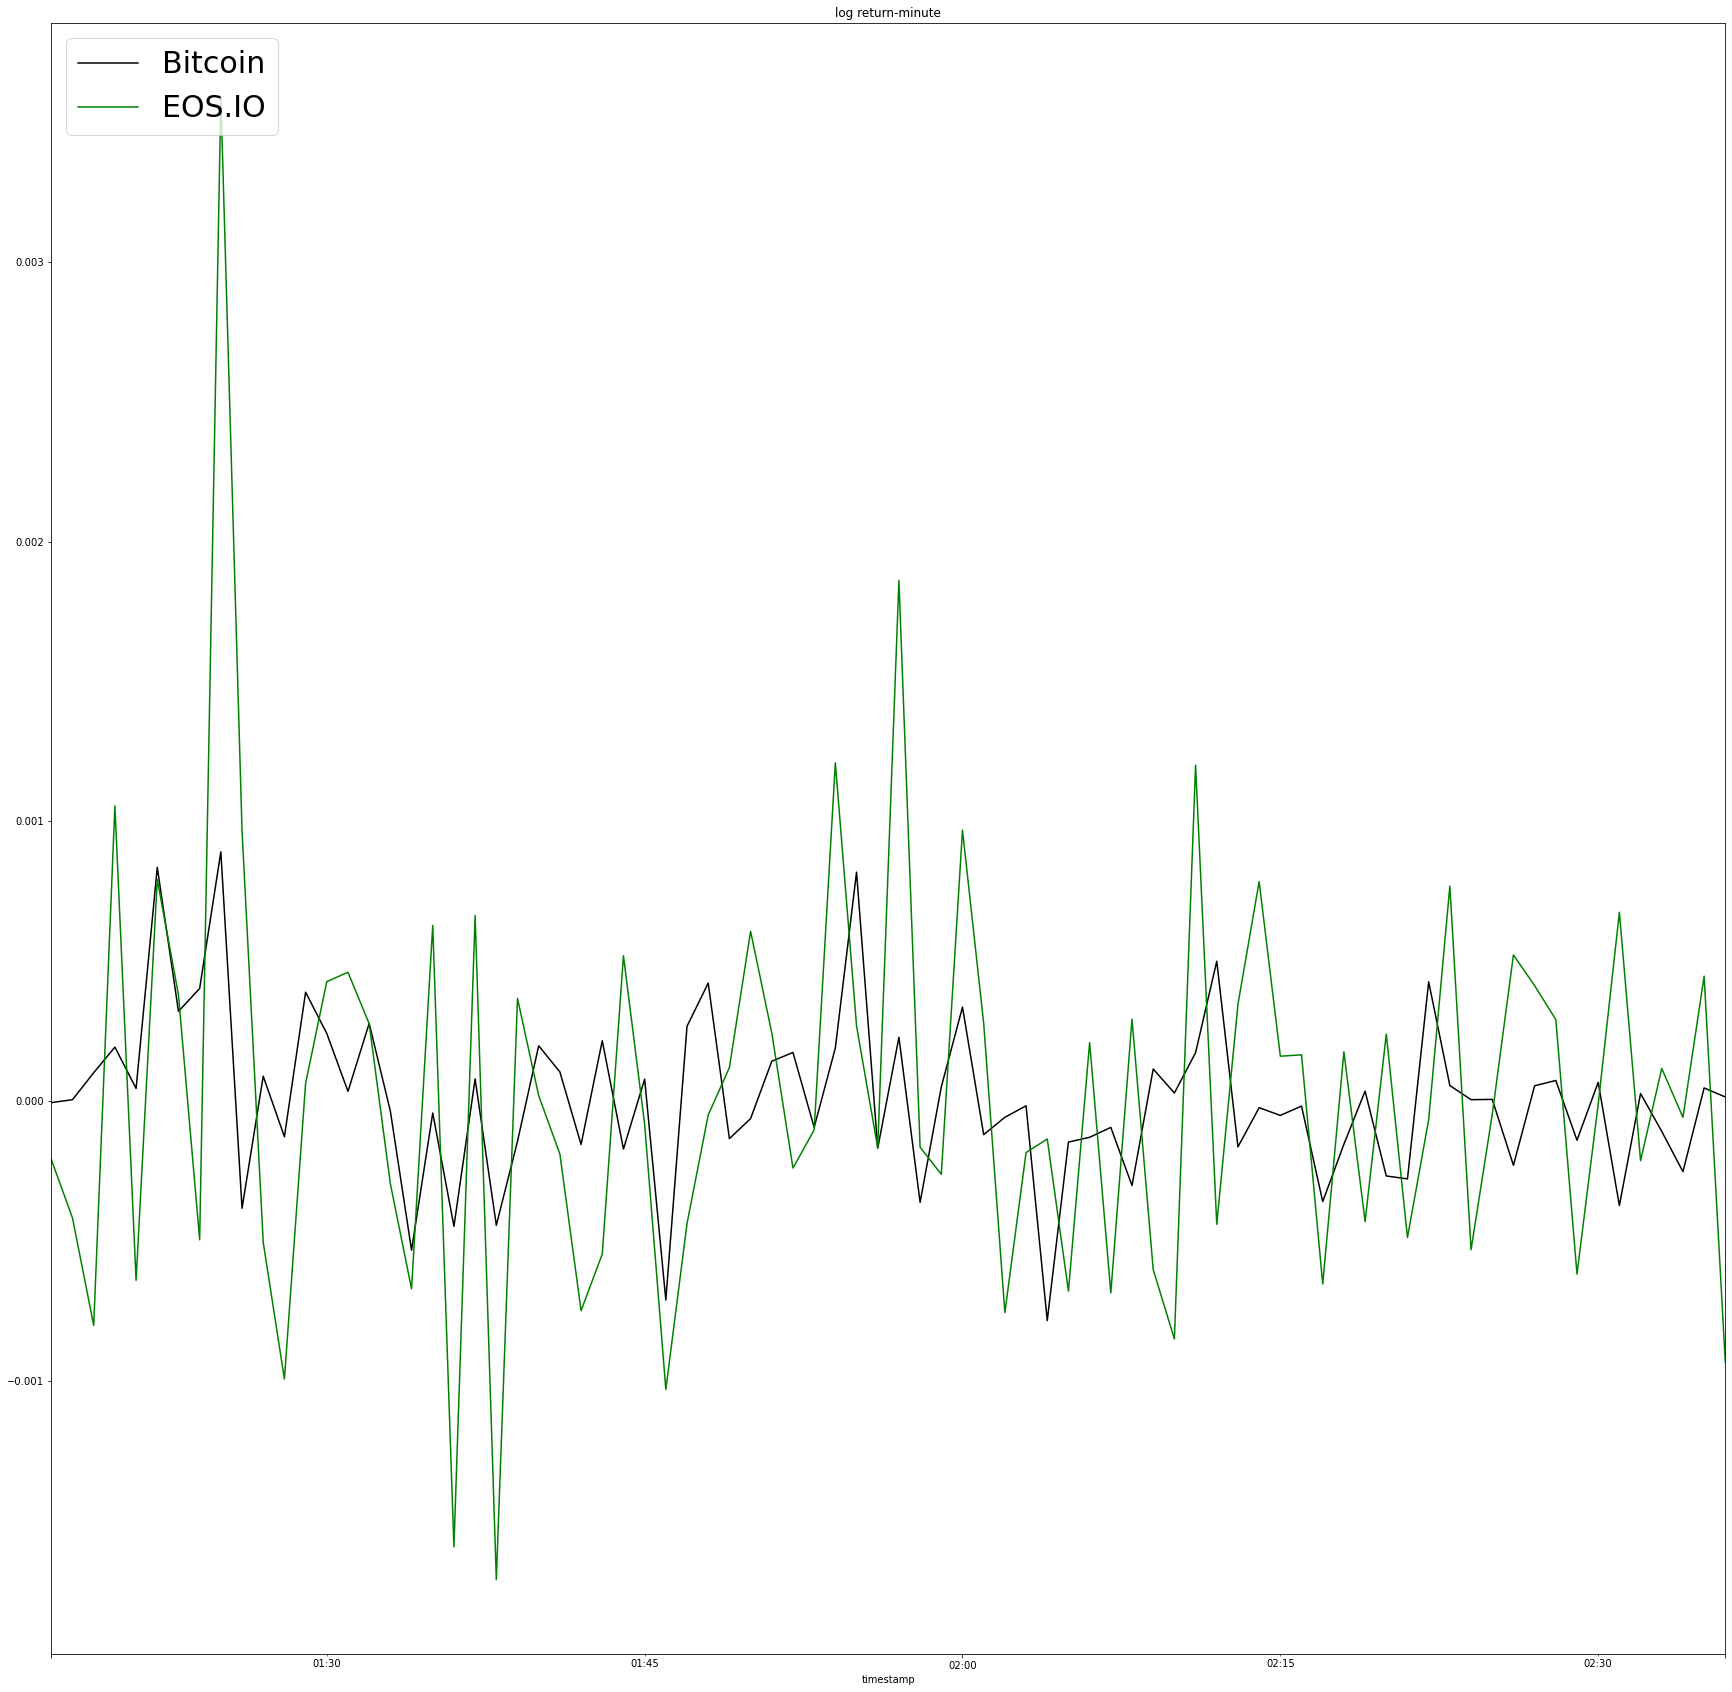

In [97]:
df[['Bitcoin','EOS.IO']].loc[:start_dt+pd.Timedelta(hours = 1,minutes=19,seconds=59)].plot(figsize = (30,30),color=['black','green']
                                                                                            ,title = 'log return-minute').legend(loc='upper left',prop={'size': 30})

## non-stationary volatility structure

 Interest in the cryptomarket has exploded, so the volatility and correlation structure in our data are likely to be highly non-stationary.

 **Daily Realized Volatility: Close-Close**

$$\sigma_{realized} = \sqrt{N}\sqrt{ \frac{1}{n-2} \sum\limits_{i=1} ^{n-1} (r_t-\bar r)^2 }$$

$r_t =\log\frac{C_t}{C_{t-1}}$: rate of return

$ \bar r =\frac{1}{n} \sum\limits_{n}^{t=1}r_t$: average rate of return

In [ ]:
def realized(df, n =24*60, N= 5):
    lrt = log_return(df['Close'],periods=1)
    lrt.rolling(n).std()*sqrt(N)
    df['vol_realized'] = sqrt(sum((r_i - rt_mean) ** 2 for r_i in rt) * N / (len(rt) - 1))
    return df
